In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## Introduction

In this Notebook we will use binary classification algoithms to solve the Spaceship Titanic Challenge. 

Our goal is to predict wether a passenger is transported to an other dimension after the crash of the space titanic or not. 



![spaceship](https://qph.cf2.quoracdn.net/main-qimg-c8dabaf5c8e26b056f1eda7728c1d002-lq)

## The Dataset

* **Train Data:**
    * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
    * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    * **Destination** - The planet the passenger will be debarking to.
    * **Age** - The age of the passenger.
    * **VIP** - Whether the passenger has paid for special VIP service during the voyage.
    * **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    * **Name** - The first and last names of the passenger.
    * **Transported **- Whether the passenger was transported to another dimension. This is the target, the column we are trying to predict.
    
    
* **Test Data:**
    * Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

## 2. Loading the Data 

In [3]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

print('The Training Set has:',train.shape[0] ,'rows and' ,train.shape[1] ,'columns')
print('The Test Set has:',test.shape[0],'rows and',test.shape[1],'columns')

The Training Set has: 8693 rows and 14 columns
The Test Set has: 4277 rows and 13 columns


In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 3. Checking the state of the Data

### Missing values

In [5]:
print('The train dataset has', sum(train.isnull().sum()), 'missing values')
print('The test dataset has', sum(test.isnull().sum()), 'missing values')

The train dataset has 2324 missing values
The test dataset has 1117 missing values


### Distribution of the missing values

We can see that every feature except for the Passenger ID contains null values.

In [6]:
print('Training Set:')
print(train.isnull().sum())
print('')
print('Test Set:')
print(test.isnull().sum())

Training Set:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Test Set:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Unique Values in every column

In [7]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

### Data Types
All Data needs to be transformed into numeric values for later model building

In [8]:
print(train.dtypes)

# Saving the object features as a list 
obj = train.select_dtypes(['object']).columns

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


### Checking the distribution of our target feature ('Transported') to see if we have to change our sampling 
The target feature seems to be nearly even distributed, so we have to do no over- or undersampling

<AxesSubplot:xlabel='Transported', ylabel='count'>

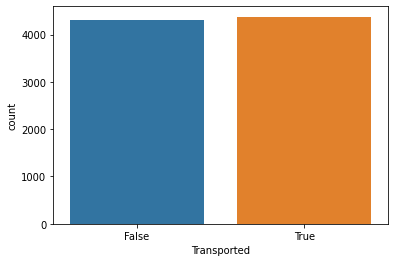

In [9]:
sns.countplot(data = train, x = "Transported")

## 4. Explorative Data Analysis (EDA)

In [10]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Continuous Feature Correlation with Transported

Age            -0.075026
RoomService    -0.244611
FoodCourt       0.046566
ShoppingMall    0.010141
Spa            -0.221131
VRDeck         -0.207075
Transported     1.000000
Name: Transported, dtype: float64


<AxesSubplot:>

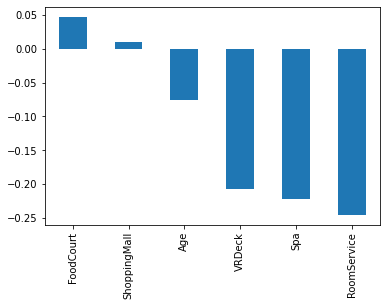

In [12]:
print(train.corr()['Transported'])

train.corr()['Transported'].drop('Transported').sort_values(ascending = False).plot(kind = 'bar')

### Age Distribution

We can see that:

* Most Passengers are in the range from 13 to 35 years old
* Younger Passengers  in the range from 0 - 18 have a higher probability to get transported than older passengers 


<AxesSubplot:xlabel='Age', ylabel='Count'>

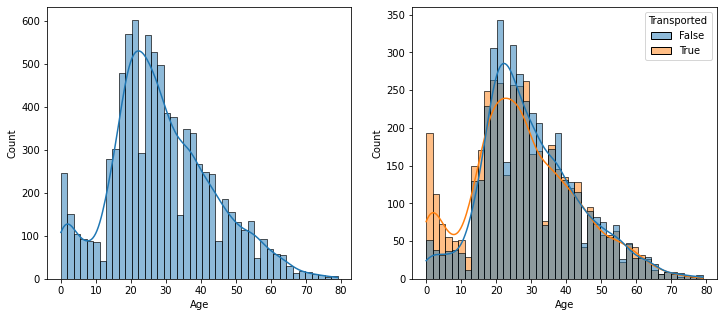

In [13]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,5))

sns.histplot(x = "Age", data = train, kde = True, ax = axs[0])
sns.histplot(x = "Age", data = train, hue = "Transported", kde = True, ax = axs[1])

### VRDeck, Spa, Room service and Shopping Mall

We'll now have a closer look at the Spaceship Titanic's luxury amenities and how their relationship to the Transported feature looks like.

* Most of the passengers used very little to none luxury amenities
* Except for the shooping mall users, the passengers who used none to very little luxury amenities, have a higher chance to be rescued. 

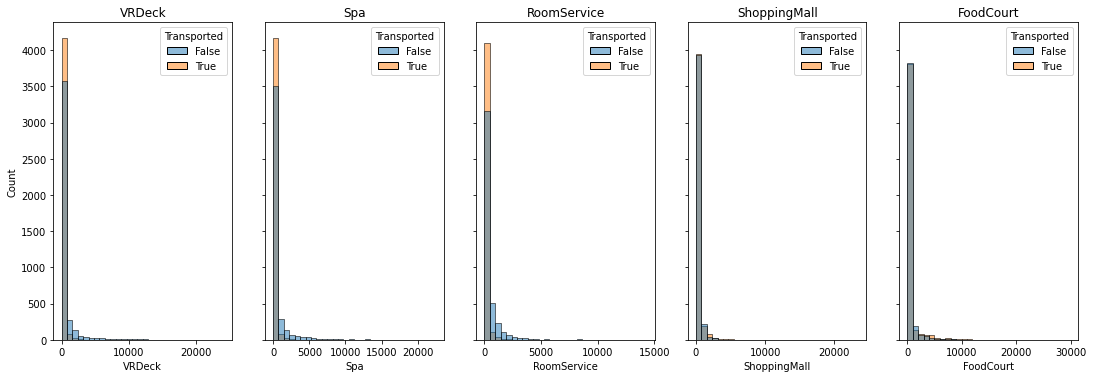

In [14]:
lux_am = ['VRDeck', 'Spa', 'RoomService', 'ShoppingMall', 'FoodCourt']

fig, axs = plt.subplots(ncols = len(lux_am), nrows = 1, sharey='row', figsize = (15,5))
fig.tight_layout()


for i, feat in enumerate(lux_am):
    ax = sns.histplot(data = train, x = feat, bins = 30,hue = 'Transported', ax = axs[i])
    ax.set_title(feat)

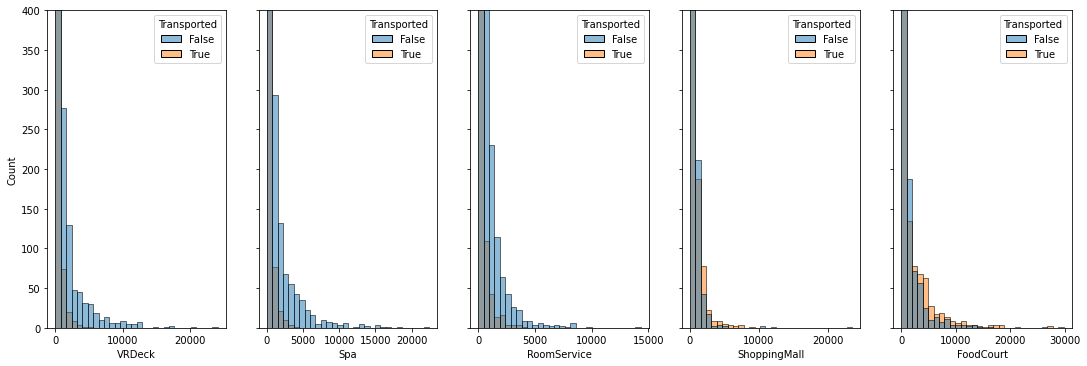

In [15]:
# zooming in to the guests who used more of the luxury amenities
fig, axs = plt.subplots(ncols = len(lux_am), nrows = 1, sharey='row', figsize = (15,5))
fig.tight_layout()


for i, feat in enumerate(lux_am):
    if i == 0:
        sns.histplot(data = train, x = feat, bins = 30,hue = 'Transported', ax = axs[i])
        plt.ylim(0, 400)
        ax.set_title(feat)
    else:
        sns.histplot(data = train, x = feat, bins = 30,hue = 'Transported', ax = axs[i])
        ax.set_title(feat)
        handles, labels = ax.get_legend_handles_labels()

        

### Next, we take a look at the distribution of the categorial features

In [16]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


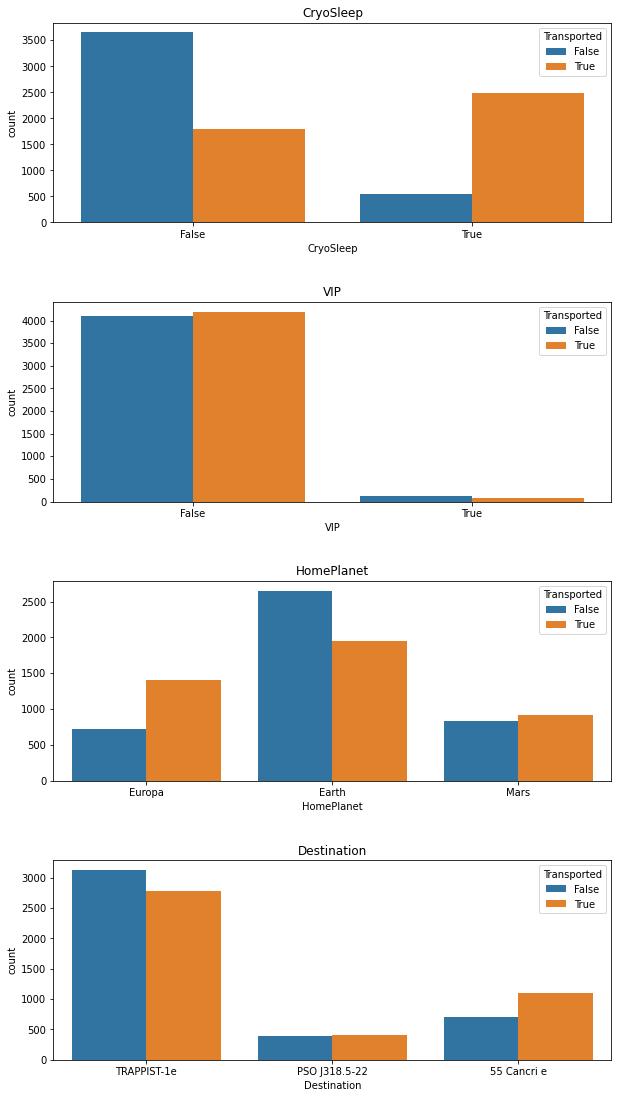

In [17]:
cat_feat = ['CryoSleep', 'VIP', 'HomePlanet', 'Destination']

fig.tight_layout()

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1        # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots



fig=plt.figure(figsize=(10,16))
for i, value in enumerate(cat_feat):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=value, axes=ax, hue='Transported')
    ax.set_title(value)
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

### Qualitative Features

Since we can't plot the qualitative Features we just take a quick look at them:

In [18]:
train[['PassengerId', 'Cabin', 'Name']].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


## 5. Feature Engineering

In the next step we want to work on our features to get a better result from our model.

Steps we will undergo are:

* Classifying the age groups
* Get the total expenditures as the sum of all spendings on amentities 
* Based on the previous step, classify passengers who had and had not done spendings
* Extract the Group Size 
* Extract the location data from the cabin column
* Extract the family size

### Age groups 

In [19]:
dfs = [train, test]

for i in dfs:
    i['AgeGroup'] = np.nan
    i.loc[(i['Age'] < 12), 'AgeGroup'] = 'Age_0-12'
    i.loc[(i['Age'] > 12) & (i['Age'] < 18), 'AgeGroup'] = 'Age_13-17'
    i.loc[(i['Age'] > 17) & (i['Age'] < 26), 'AgeGroup'] = 'Age_18-25'
    i.loc[(i['Age'] > 25) & (i['Age'] < 31), 'AgeGroup'] = 'Age_26-30'
    i.loc[(i['Age'] > 30) & (i['Age'] < 51), 'AgeGroup'] = 'Age_31-50'
    i.loc[(i['Age'] > 50), 'AgeGroup'] = 'Age_51+'


Text(0.5, 1.0, 'Distribution of Age groups')

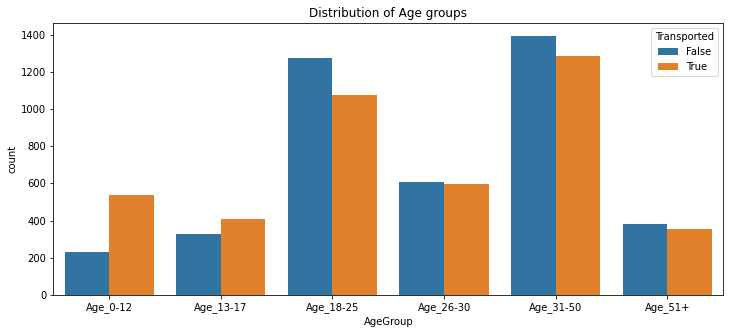

In [20]:
#Distribution of the new feature
plt.figure(figsize = (12,5))

sns.countplot(data = train, x = "AgeGroup", hue = "Transported", 
              order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])

plt.title('Distribution of Age groups')

### Total expenditure

In [21]:
#Adding the total expenditures column
for i in dfs:
    i['Total_Exp'] = np.nan
    i['Total_Exp']= i[lux_am].sum(axis=1)
    
#Classifying Passengers who did and who didn't spend money
#Spent Money: 1
#Didn't spend money: 0


def spent(x):
    if x > 0:
        return 1
    else:
        return 0

for i in dfs:
    i['SpentMoney'] = i['Total_Exp'].apply(lambda x: spent(x))


<AxesSubplot:title={'center':'Customers who spent money'}, xlabel='SpentMoney', ylabel='count'>

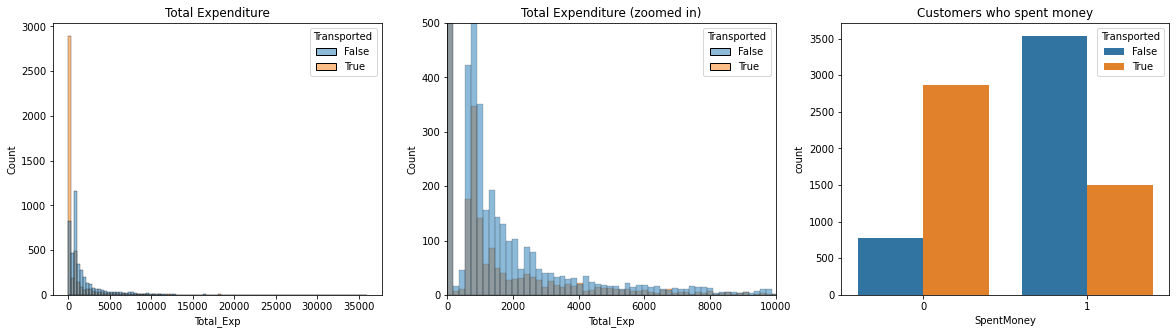

In [22]:
#Plotting the distribution of the new feature
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.title('Total Expenditure')
sns.histplot(data = train, x = 'Total_Exp', hue = 'Transported', bins = 100)

plt.subplot(1,3,2)
plt.title('Total Expenditure (zoomed in)')
sns.histplot(data = train, x = 'Total_Exp', hue = 'Transported', bins =200)
plt.xlim([0,10000])
plt.ylim([0, 500])

plt.subplot(1,3,3)
plt.title('Customers who spent money')
sns.countplot(data = train, x = "SpentMoney", hue = 'Transported')
